In [1]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [2]:
region = "california"
catalog = "scedc"
mkpath("./results/$region/")

"./results/california"

In [3]:
df = CSV.read("./catalogs/$catalog.csv", DataFrame);
first(df,5)

5×6 DataFrame
 Row │ Datetime                 Latitude  Longitude  Depth    Magnitude  Magni ⋯
     │ DateTime                 Float64   Float64    Float64  Float64    Strin ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1932-01-02T16:42:53.680    33.903   -117.645      6.0       2.73  l     ⋯
   2 │ 1932-01-03T17:58:50.010    32.0     -116.0        6.0       3.0   h
   3 │ 1932-01-04T21:30:50.960    33.771   -117.494      6.0       2.0   h
   4 │ 1932-01-05T02:37:57.960    33.559   -118.442      6.0       1.5   h
   5 │ 1932-01-06T08:08:58.620    34.143   -117.475      6.0       2.0   h     ⋯
                                                                1 column omitted

In [4]:
# Using describe function to get statistics of a dataset
describe(df)

6×7 DataFrame
 Row │ variable        mean      min                      median               ⋯
     │ Symbol          Union…    Any                      Any                  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Datetime                  1932-01-02T16:42:53.680  2002-02-14T22:47:53. ⋯
   2 │ Latitude        34.3568   32.0                     34.117
   3 │ Longitude       -117.059  -122.0                   -116.826
   4 │ Depth           6.84918   0.0                      6.0
   5 │ Magnitude       1.43175   0.01                     1.35                 ⋯
   6 │ Magnitude_Type            b                                            
                                                               4 columns omitted

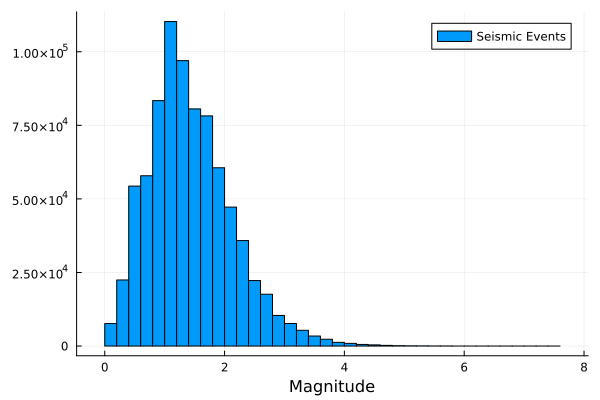

In [77]:
fig = Plots.histogram(df[:,:Magnitude],
                    bins = 40, xlabel = "Magnitude", label="Seismic Events")

savefig("./results/$region/histogram_events_magnitudes.png")
fig

In [20]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end

join_on_counted_no_mag_bounds (generic function with 1 method)

In [21]:
function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [22]:
trim_year = 1932
magnitude_threshold = 0.0;

In [23]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

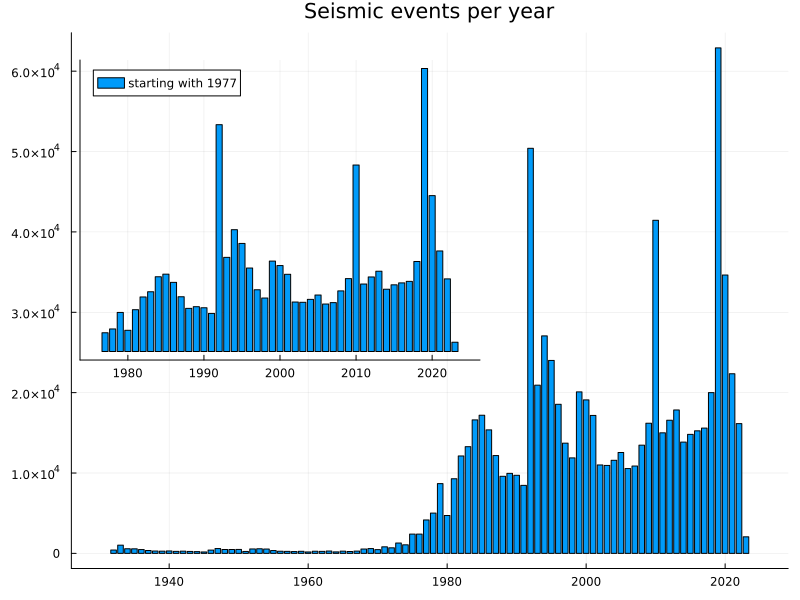

In [25]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

# Inset plot
# Select from 1976 onwards 
bar!(df_counted.Year[end-46:end], df_counted.count[end-46:end], 
	orientation=:vertical,
    inset = bbox(0.1, 0.1, 0.5, 0.5, :top, :left), 
    label="starting with 1977",
    # ticks = nothing,
    yticks = nothing,
    subplot = 2,
    bg_inside = nothing)
	# label="Seismic Events")


savefig("./results/$region/events_per_year.png")
fig

In [26]:
trim_year = 1977
magnitude_threshold = 0.0;

In [27]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

In [28]:
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	maxmag=minmag+1
	df_counted_mag_extra = join_on_counted(df,trim_year,minmag,maxmag)

	leftjoin!(df_counted, df_counted_mag_extra, on=:Year,makeunique=true)
	df_counted[!,Symbol("count_mag_$minmag")] = replace(df_counted[!,Symbol("count_mag_$minmag")], missing => 0)
end

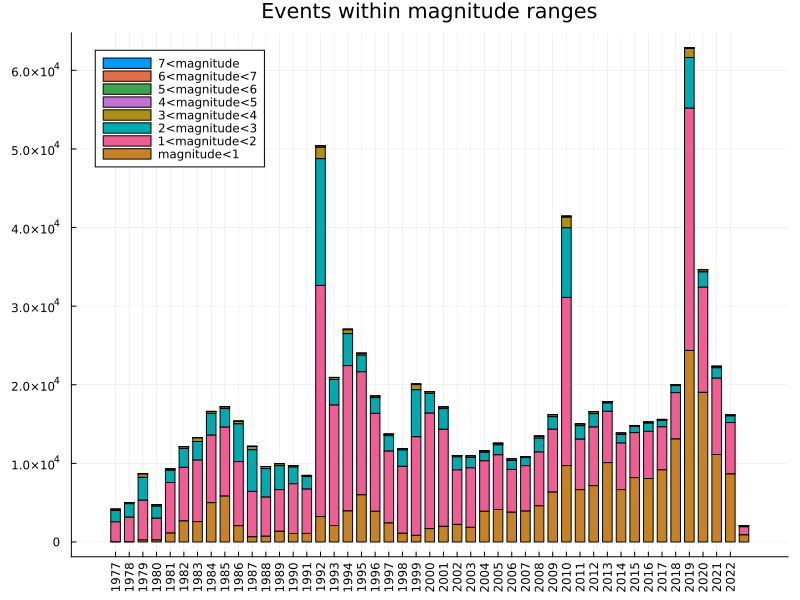

In [29]:
mags=[]
for minmag=0:7
	push!(mags,df_counted[!,Symbol("count_mag_$minmag")])
end

ticklabels = string.(collect(minimum(df_counted.Year):maximum(df_counted.Year)))

fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3] mags[2] mags[1] ],
			bar_position = :stack,
			bar_width=0.7,
			xticks=(1:46, ticklabels),
			xrotation=90,
			title="Events within magnitude ranges",
			label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" "1<magnitude<2" "magnitude<1"])

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags.png")
fig


In [30]:
# Test to check if all quakes have been properly placed in magnitude bracket 
quakes=0
for minmag=0:7
	quakes+= sum(df_counted[!,Symbol("count_mag_$minmag")])
end
quakes == sum(df_counted[!,:count])

true

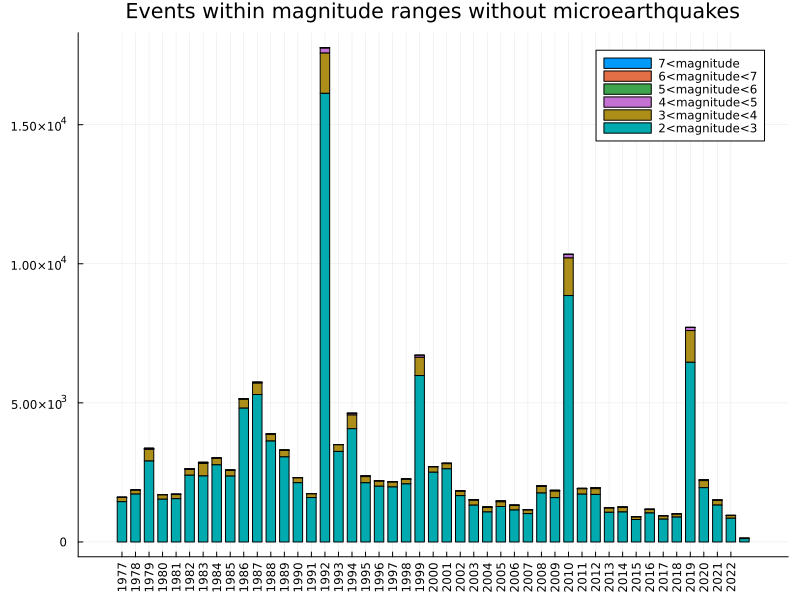

In [31]:
fig = groupedbar([ mags[8] mags[7] mags[6] mags[5] mags[4] mags[3]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Events within magnitude ranges without microearthquakes",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" ]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_no_microearthquakes.png")
fig

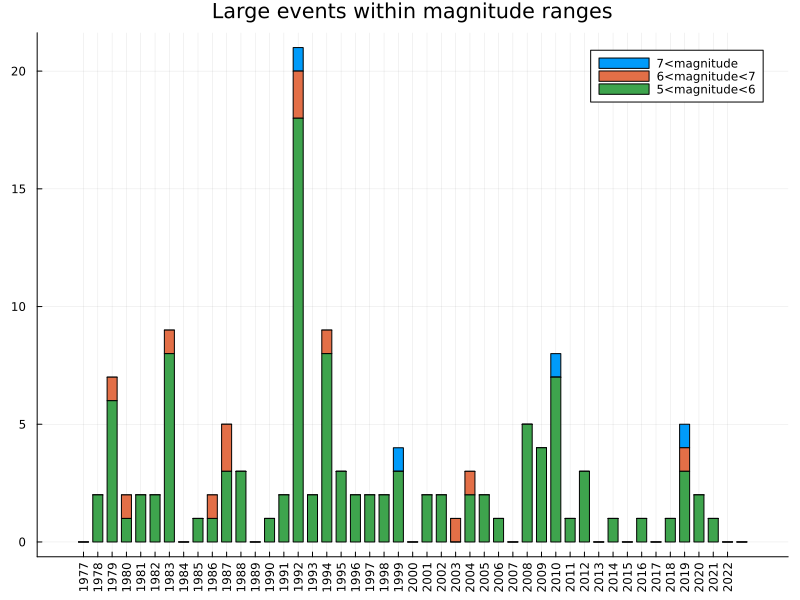

In [32]:
fig = groupedbar([ mags[8] mags[7] mags[6]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:46, ticklabels),
				xrotation=90,
				title="Large events within magnitude ranges",
				label=["7<magnitude" "6<magnitude<7" "5<magnitude<6"]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/events_per_year_mags_large.png")
fig

In [33]:
using GLMakie, CairoMakie

In [34]:
# Theme
seismic_theme = Theme(
    # fontsize = 24,
    Axis3 = (
        xlabelsize = 24,
        xlabeloffset = 40,
        xticklabelsize  = 16,

        ylabelsize = 24,
        ylabeloffset = 40,
        yticklabelsize  = 16,

        zlabelsize = 24,
        zlabeloffset = 60,
        zticklabelsize  = 16
        )
                    );

In [71]:
function seismic_scatter_2D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	
	CairoMakie.activate!()
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	fig = Figure( resolution=(1080, 720))
	ax = Axis(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude",
	)

	markerSizes = [1.7^x for x in region.Magnitude];

	limits!(mapcoords["minLon"], mapcoords["maxLon"], mapcoords["minLat"], mapcoords["maxLat"])
	
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		CairoMakie.image!( 
				range(mapcoords["minLon"],mapcoords["maxLon"],step=0.1),
				range(mapcoords["minLat"],mapcoords["maxLat"],step=0.1),
			    rotr90(img*0.75),
				)
	end

	sc = CairoMakie.scatter!(ax, region.Longitude, region.Latitude,
	    markersize= markerSizes,
		markeralpha = region.Depth,
	    color= region.Magnitude,
	    colormap= (Reverse(:devon), 1),
	    strokewidth= 0.5,
	    shading= false
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))

	return fig
end

seismic_scatter_2D (generic function with 2 methods)

In [69]:
function seismic_scatter_3D(region, trim_year, magnitude_threshold, with_image, img=nothing)
	GLMakie.activate!()
	set_theme!(seismic_theme)
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
		            "minDepth"=>minimum(region.Depth),
		            "maxDepth"=>maximum(region.Depth),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	mapcoords["maxDepth"]=maximum(region.Depth)

	fig = Figure( resolution=(1080, 720))

	# scene = Scene(resolution = (600, 400))
	# scale!(scene, 1, 2, 2)

	# lscene = LScene(fig[1, 1])
	# # surface!(lscene, ...)
	
	# cam = cameracontrols(lscene.scene)
	# cam.lookat[] = [0, 0, 200]
	# cam.eyeposition[] = [3000, 200, 2000]
	# update_cam!(lscene.scene, cam)

	# parent = Scene(backgroundcolor=:white)
	# cam3d!(parent)

	# camc = cameracontrols(parent)
	# update_cam!(parent, camc, Vec3f(0, 0, 0), Vec3f(4.0, 0, 0))
	
	# cam = Makie.camera(scene)
	
	ax = Axis3(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude", zlabel = "Depth",
		# viewmode = :fit,
	    perspectiveness=0.5,
		aspect=(1, 1.5, 0.5)
	)
	# scale!(ax.scene,1.0,1.0,0.7)
	
	markerSizes = [1.7^x for x in region.Magnitude];
	
	sc = GLMakie.scatter!(ax, region.Longitude, region.Latitude, -region.Depth;
		markersize= markerSizes,
		color= region.Magnitude,
		colormap= (Reverse(:devon), 0.99),
		strokewidth= 0.5,
		shading= false,
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		image!(ax , 
				# mapcoords["minLon"] .. mapcoords["maxLon"],
				# mapcoords["minLat"] .. mapcoords["maxLat"],

				range(mapcoords["minLon"],mapcoords["maxLon"],step=0.1),
				range(mapcoords["minLat"],mapcoords["maxLat"],step=0.1),
			    rotr90(img*0.7); 
			    transformation=(:xy,10)# -mapcoords["maxDepth"]),

				)
	end

    return fig
end

seismic_scatter_3D (generic function with 2 methods)

In [66]:
img_path = "./maps/california_topo2.png"
img = load(img_path);

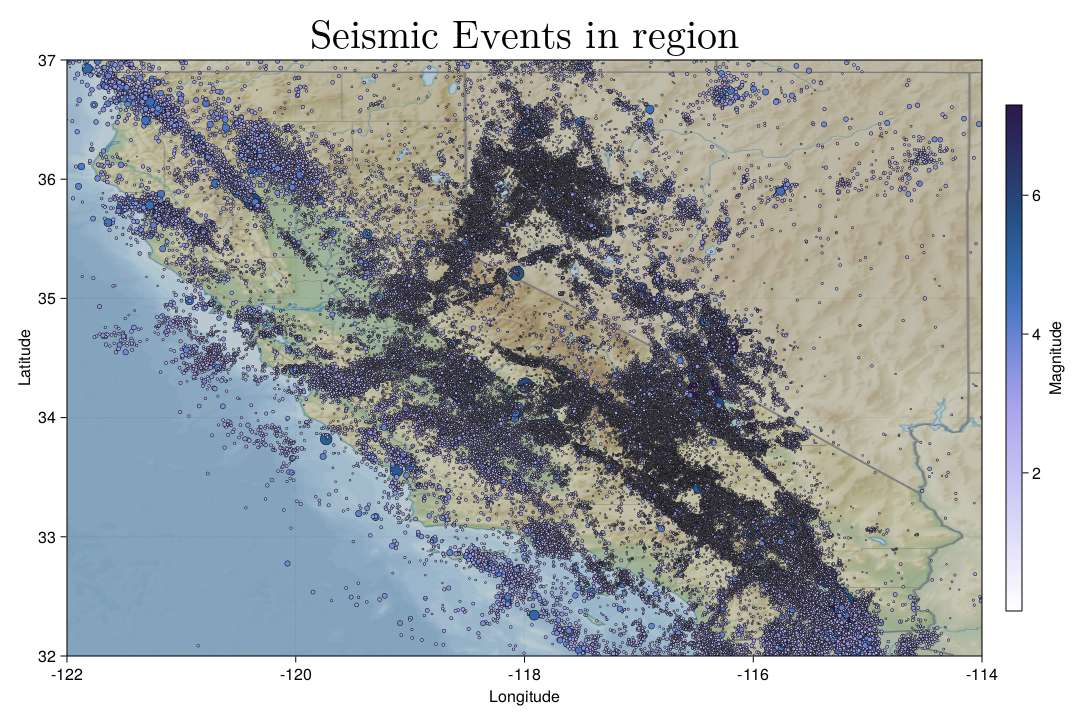

In [72]:
fig = seismic_scatter_2D(df, trim_year, magnitude_threshold, true, img)
save("./results/$region/2D_mag_$magnitude_threshold.png", fig)
fig

In [70]:
fig = seismic_scatter_3D(df, trim_year, magnitude_threshold, true, img)
save("./results/$region/3D_mag_$magnitude_threshold.png", fig)
fig

In [5]:
trim_year = 1977

1977

In [6]:
df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)),:]

784754×6 DataFrame
    Row │ Datetime                 Latitude  Longitude  Depth    Magnitude  Ma ⋯
        │ DateTime                 Float64   Float64    Float64  Float64    St ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 1977-01-01T01:00:51.800    34.458   -117.96       4.3       2.93  l  ⋯
      2 │ 1977-01-01T01:25:53.910    34.363   -118.674     19.0       1.5   h
      3 │ 1977-01-01T04:39:53.120    32.809   -115.503      6.8       1.6   h
      4 │ 1977-01-01T10:36:57.610    34.143   -117.455      0.0       1.99  h
      5 │ 1977-01-01T12:08:59.700    35.271   -118.604      4.8       1.8   h  ⋯
      6 │ 1977-01-01T15:40:52.570    32.462   -115.394      6.0       2.0   h
      7 │ 1977-01-01T19:21:50.100    33.014   -116.297      7.0       1.9   h
      8 │ 1977-01-01T20:22:52.200    34.051   -116.536      0.7       2.02  h
   ⋮    │            ⋮                ⋮          ⋮         ⋮         ⋮         ⋱
 784748 │ 2023-03-06T23:56:56.120    34.013   -118.564     13.7       1.69  l  ⋯
 784749 │ 2023-03-07T01:28:53.150    36.091   -117.85       1.8       1.09  l
 784750 │ 2023-03-07T05:02:51.990    33.883   -117.055     17.1       1.07  l
 784751 │ 2023-03-07T05:39:58.280    33.153   -115.981      5.7       2.34  l
 784752 │ 2023-03-07T05:43:59.860    35.651   -117.48      10.9       1.39  l  ⋯
 784753 │ 2023-03-07T07:11:55.040    33.73    -117.852      9.3       1.69  l
 784754 │ 2023-03-07T07:30:55.530    33.714   -116.819     15.4       0.89  l
                                                1 column and 784739 rows omitted

In [7]:
# Make directory if it does not exist
mkpath("./data/")

# Write to CSV
CSV.write("./data/$region.csv", df_trimmed)

"./data/california.csv"